In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os

# Base Directory for Drive
BASE_DIR = "/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project"

DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
MODELS_DIR = os.path.join(BASE_DIR, "models")
SRC_DIR = os.path.join(BASE_DIR, "src")

for d in [BASE_DIR, DATA_DIR, RAW_DIR, PROCESSED_DIR, MODELS_DIR, SRC_DIR]:
    os.makedirs(d, exist_ok=True)

BASE_DIR, RAW_DIR, PROCESSED_DIR, MODELS_DIR, SRC_DIR


('/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project',
 '/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project/data/raw',
 '/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project/data/processed',
 '/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project/models',
 '/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project/src')

In [ ]:
import pandas as pd
import os

RAW_FILE = os.path.join(RAW_DIR, "creditcard.csv")
PROCESSED_FILE = os.path.join(PROCESSED_DIR, "creditcard_clean.csv")

df = pd.read_csv(RAW_FILE)
print("Raw shape:", df.shape)
print(df.head())

# --- Simple cleaning ---
# 1) Drop duplicates
df = df.drop_duplicates()

# 2) Drop rows with missing values
df = df.dropna()

print("After cleaning:", df.shape)

# Save to processed
df.to_csv(PROCESSED_FILE, index=False)
print("Saved cleaned data to:", PROCESSED_FILE)


Raw shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Split Test, Train, Val

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

pipe.fit(X_train, y_train)

# threshold on VAL
val_scores = pipe.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_scores)

precision_t, recall_t, thresholds_t = precision[:-1], recall[:-1], thresholds
target_recall = 0.90
valid = np.where(recall_t >= target_recall)[0]
best_idx = valid[np.argmax(precision_t[valid])]
chosen_threshold = thresholds_t[best_idx]

print("Chosen threshold (from VAL):", chosen_threshold)
print("VAL Precision/Recall:", precision_t[best_idx], recall_t[best_idx])

# Refit on TRAIN+VAL
pipe.fit(X_trainval, y_trainval)

# Final evaluation
test_scores = pipe.predict_proba(X_test)[:, 1]
y_pred_tuned = (test_scores >= chosen_threshold).astype(int)

print(classification_report(y_test, y_pred_tuned, digits=4))
print(confusion_matrix(y_test, y_pred_tuned))


Chosen threshold (from VAL): 0.478208766670151
VAL Precision/Recall: 0.05084745762711865 0.9078947368421053
              precision    recall  f1-score   support

           0     0.9998    0.9734    0.9864     56651
           1     0.0522    0.8737    0.0986        95

    accuracy                         0.9732     56746
   macro avg     0.5260    0.9236    0.5425     56746
weighted avg     0.9982    0.9732    0.9849     56746

[[55145  1506]
 [   12    83]]


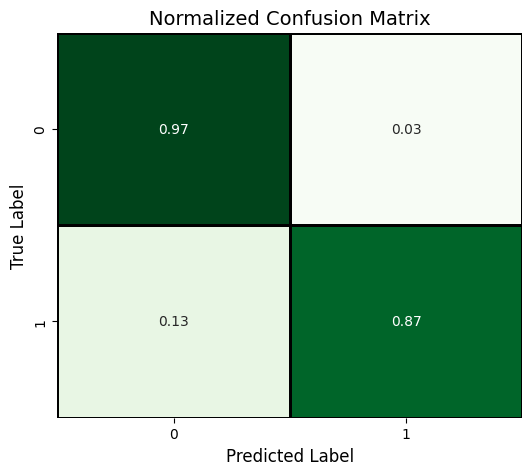

In [13]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

ANALYSIS_DIR = os.path.join(BASE_DIR, "analysis_outputs")

cm = confusion_matrix(y_test, y_pred_tuned)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Greens',
    linewidths=1,
    linecolor='black',
    cbar=False
)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Normalized Confusion Matrix", fontsize=14)

plt.savefig(os.path.join(ANALYSIS_DIR, "ConfusionMatrix_tuned.png"), dpi=300, bbox_inches='tight')

plt.show()


In [14]:
import joblib
import os
from datetime import datetime

# Base dirs
BASE_DIR = "/content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project"
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_PATH = os.path.join(MODELS_DIR, f"fraud_model_tuned_{timestamp}.pkl")

joblib.dump(pipe, MODEL_PATH)
print("Saved model to:", MODEL_PATH)


Saved model to: /content/drive/MyDrive/DataAnalysis_Portfolio/fraud_detection_project/models/fraud_model_tuned_20260202_0317.pkl


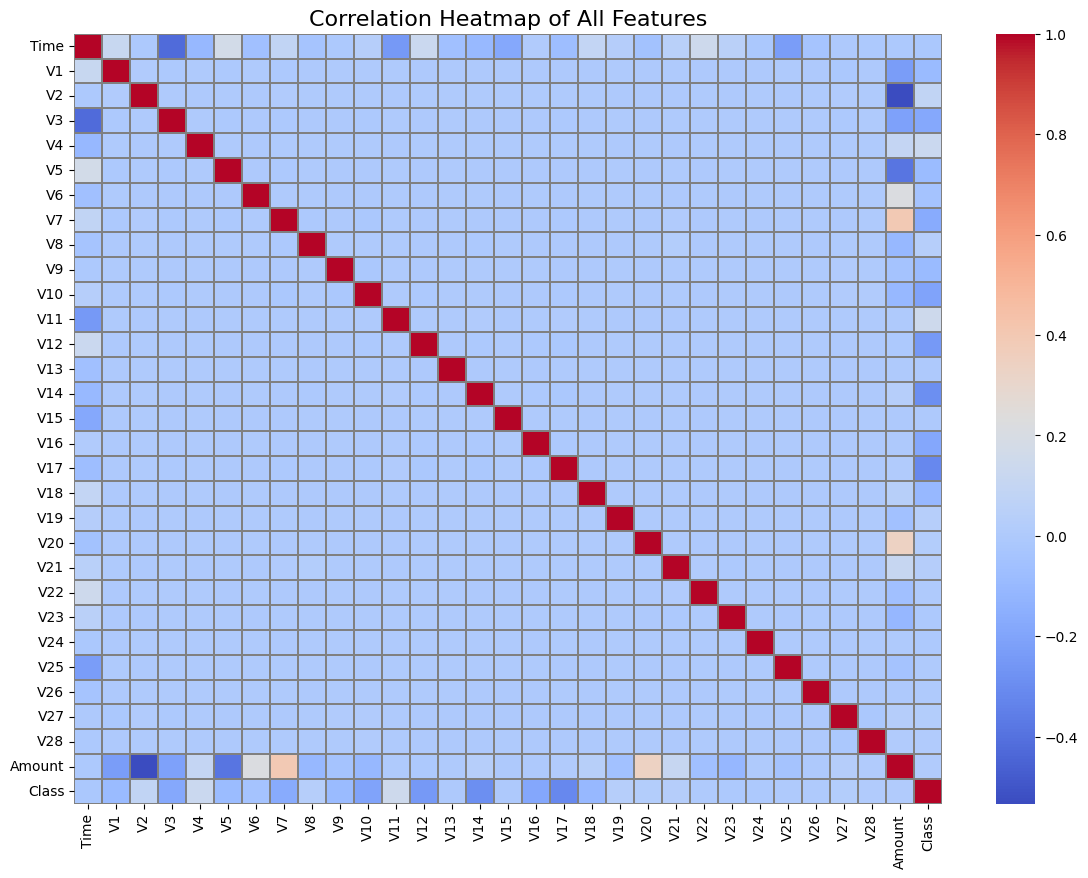

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    linewidths=0.1,
    linecolor='gray'
)
plt.title("Correlation Heatmap of All Features", fontsize=16)
plt.savefig(os.path.join(ANALYSIS_DIR, "Correlation_Heatmap.png"), dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Extract model from pipeline
model = pipe.named_steps['clf']
scaler = pipe.named_steps['scaler']

feature_names = X_train.columns # Feature Names
coeffs = model.coef_[0] # Coefficients

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coeffs,
    "Abs_Importance": np.abs(coeffs)
})

importance_df = importance_df.sort_values("Abs_Importance", ascending=False)

plt.savefig(os.path.join(ANALYSIS_DIR, "Feature_importance.png"), dpi=300, bbox_inches='tight')


importance_df.head(15)


,Feature,Coefficient,Abs_Importance
29,Amount,1.621455,1.621455
14,V14,-1.497686,1.497686
1,V1,1.393505,1.393505
12,V12,-1.254749,1.254749
10,V10,-1.218284,1.218284
4,V4,1.207536,1.207536
5,V5,0.891382,0.891382
17,V17,-0.861413,0.861413
22,V22,0.663440,0.663440
20,V20,-0.650852,0.650852


<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-513754212.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


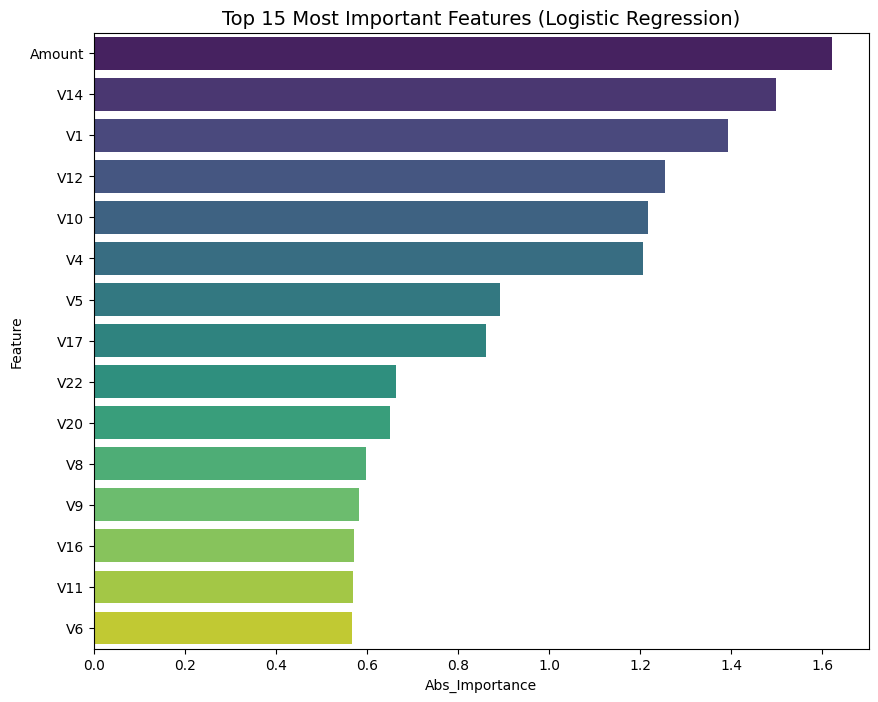

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x="Abs_Importance",
    y="Feature",
    data=importance_df.head(15),
    palette="viridis"
)
plt.title("Top 15 Most Important Features (Logistic Regression)", fontsize=14)

plt.savefig(os.path.join(ANALYSIS_DIR, "LR_15Imp_Features.png"), dpi=300, bbox_inches='tight')

plt.show()


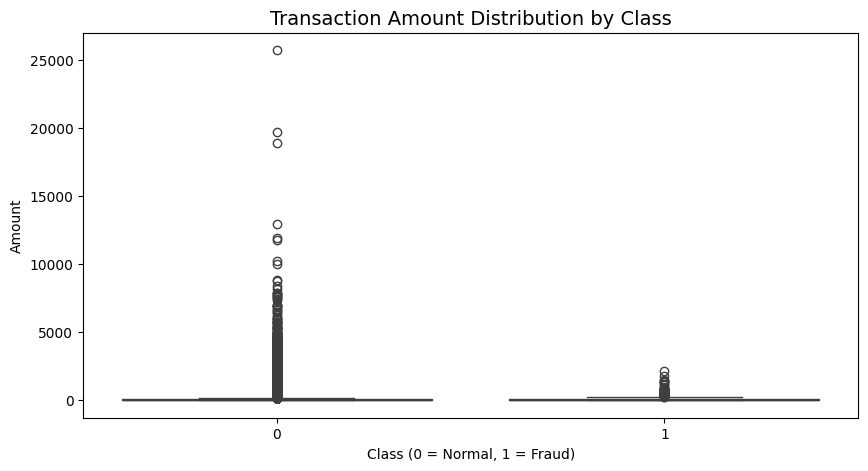

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Class"], y=df["Amount"])
plt.title("Transaction Amount Distribution by Class", fontsize=14)
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("Amount")

plt.savefig(os.path.join(ANALYSIS_DIR, "Amt_distribution.png"), dpi=300, bbox_inches='tight')

plt.show()


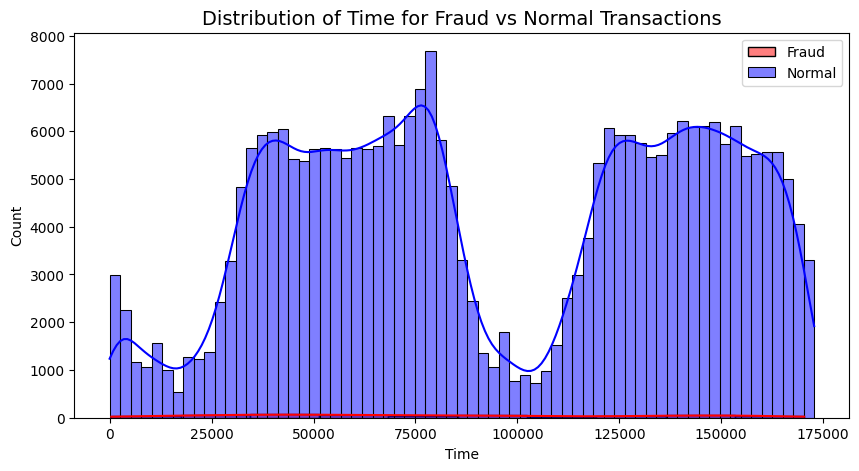

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df["Class"] == 1]["Time"], color="red", kde=True, label="Fraud")
sns.histplot(df[df["Class"] == 0]["Time"], color="blue", kde=True, label="Normal")
plt.legend()
plt.title("Distribution of Time for Fraud vs Normal Transactions", fontsize=14)

plt.savefig(os.path.join(ANALYSIS_DIR, "Time_distribution.png"), dpi=300, bbox_inches='tight')

plt.show()


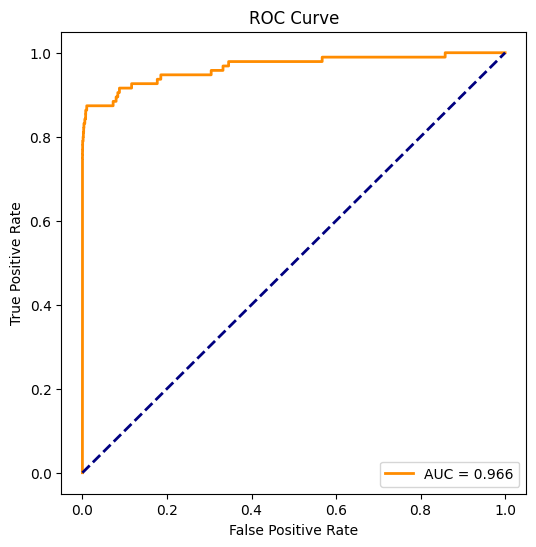

In [15]:
from sklearn.metrics import roc_curve, auc

y_proba = pipe.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.savefig(os.path.join(ANALYSIS_DIR, "ROC_Curve_tuned.png"), dpi=300, bbox_inches='tight')

plt.show()


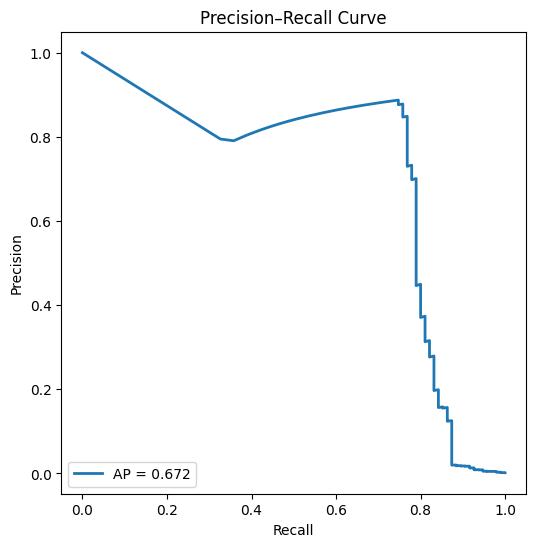

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f"AP = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")

plt.savefig(os.path.join(ANALYSIS_DIR, "Precision_Recall_Curve.png"), dpi=300, bbox_inches='tight')

plt.show()


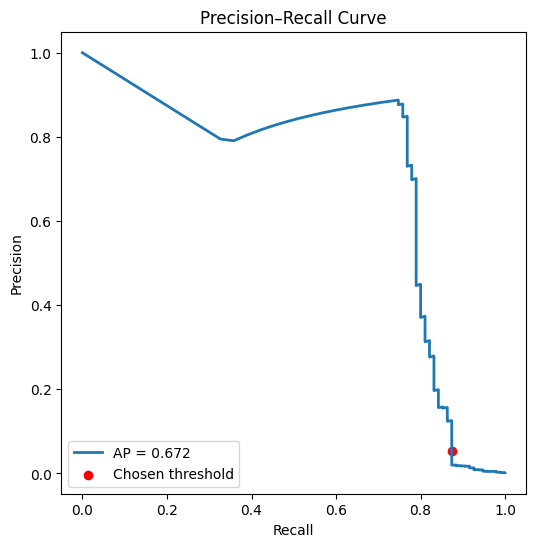

In [18]:
# Compute precision/recall at chosen threshold
from sklearn.metrics import precision_score, recall_score

y_pred_tuned = (y_proba >= chosen_threshold).astype(int)
p_thr = precision_score(y_test, y_pred_tuned, zero_division=0)
r_thr = recall_score(y_test, y_pred_tuned, zero_division=0)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f"AP = {avg_precision:.3f}")
plt.scatter(r_thr, p_thr, color="red", label="Chosen threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")

plt.savefig(os.path.join(ANALYSIS_DIR, "Precision_Recall_Curve_tuned.png"), dpi=300, bbox_inches='tight')

plt.show()
